In [1]:
import numpy as np
import matplotlib.pylab as plt
import matplotlib as mpl
from matplotlib import gridspec
import h5py
from scipy.special import gammaincc,gamma

mpl.rcParams['figure.figsize']=(8.0,6.0)    #(6.0,4.0)
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['legend.handlelength']=2
mpl.rcParams['legend.fontsize']=16
mpl.rcParams['legend.frameon']=False
mpl.rcParams['axes.labelsize']=18
mpl.rcParams['xtick.labelsize']=16
mpl.rcParams['ytick.labelsize']=16
mpl.rcParams['legend.labelspacing'] = 0.1
mpl.rcParams['xtick.minor.visible'] = True
mpl.rcParams['ytick.minor.visible'] = True
mpl.rcParams['ytick.right'] = True
mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.direction'] = 'inout'
mpl.rcParams['xtick.direction'] = 'inout'

In [2]:
def read_data(base):
    file = open(base+".xg",'r')
    data = {}
    cont = True
    while (cont):
        line = file.readline()
        if line=='':
            cont = False
            continue
        time = line[11:]
        data[time] = {}
        rad = np.zeros(650)
        value = np.zeros(650)
        line = file.readline()
        line = file.readline()
        line = file.readline()
        line = file.readline()
        for i in range(650):
            line = file.readline().split()
            rad[i] = float(line[0])
            value[i] = float(line[1])

        data[time]["rad"] = rad
        data[time]["value"] = value
        line = file.readline()
        line = file.readline()
        line = file.readline()
        line = file.readline()
        line = file.readline()
        line = file.readline()
    return data

def get_value_from_array_given_time(ds,value):

    rad_data = ds['rad']
    value_data = ds['value']


    for j in range(len(value_data)):
        if value_data[j]<value:
            interped_rad  = rad_data[j-1] + (rad_data[j]-rad_data[j-1])*(value-value_data[j-1])/(value_data[j]-value_data[j-1])
            break
        
    return interped_rad

def get_values_given_radius(ds,radius):
    results = {}
    for value in ds:
        results[value] = {}
        times = []
        interped_value = []
        for time in ds[value]:
            times.append(float(time))
            rad_data = ds[value][time]['rad']
            value_data = ds[value][time]['value']
            interped_value.append(np.interp(radius,rad_data,value_data))
        results[value]["time"] = np.asarray(times)
        results[value]["value"] = np.asarray(interped_value)
        
    results["W"] = {}
    results["W"]["time"] = results["rho"]["time"]
    results["W"]["value"] = np.sqrt(1.0/(1.0-results["v"]["value"]**2/29979245800.**2))
    results["fluid_factor"] = {}
    results["fluid_factor"]["time"] = results["rho"]["time"]
    results["fluid_factor"]["value"] = 1.0/(results["W"]["value"]/results["alpha"]["value"]*(1.0-results["v"]["value"]/29979245800.)/(1.0+results["v"]["value"]/29979245800.))
    results["lab_factor"] = {}
    results["lab_factor"]["time"] = results["rho"]["time"]
    results["lab_factor"]["value"] = results["alpha"]["value"]/results["X"]["value"]**2
    results["energy_factor"] = {}
    results["energy_factor"]["time"] = results["rho"]["time"]
    results["energy_factor"]["value"] = results["alpha"]["value"]*results["W"]["value"]*(1.0+results["v"]["value"]/29979245800.)
    return results

In [3]:
fulldata = {}
base = "../data/"
values = ['rho','temperature','ye','v','alpha','X',"M1_nue_rmsenergy_fluid_rad", 
          "M1_anue_rmsenergy_fluid_rad","M1_nux_rmsenergy_fluid_rad","M1_nue_aveenergy_fluid_rad",
          "M1_anue_aveenergy_fluid_rad","M1_nux_aveenergy_fluid_rad","M1_nue_luminosity_fluid_rad",
          "M1_anue_luminosity_fluid_rad","M1_nux_luminosity_fluid_rad","M1_nue_luminosity_lab_rad",
          "M1_anue_luminosity_lab_rad","M1_nux_luminosity_lab_rad"]
for value in values:
    fulldata[value] = read_data(base+value)

In [4]:
radii = [0.5e7,4.0e7]
data = {}
for radius in radii:
    data[radius] = get_values_given_radius(fulldata,radius)
    
times = np.zeros(len(fulldata['rho']))
emit_radius = np.zeros(len(fulldata['rho']))
i=0
for time in fulldata['rho']:
    times[i] = time
    emit_radius[i] = get_value_from_array_given_time(fulldata['rho'][time],1e11)
    
    i += 1
    
for t in fulldata['alpha']:
    lasttime = t
    
for i in range(len(fulldata['alpha'][lasttime]['rad'])):
    rad = fulldata['alpha'][lasttime]['rad']
    alpha = fulldata['alpha'][lasttime]['value']
    X = fulldata['X'][lasttime]['value']
    td = 0.0
    for j in range(len(rad)-1):
        if rad[j]>5e6:
            td += (X[j]**2-1.0)*(rad[j+1]-rad[j])

t_GR_shift = td

for i in range(len(fulldata['alpha'][lasttime]['rad'])):
    rad = fulldata['alpha'][lasttime]['rad']
    alpha = fulldata['alpha'][lasttime]['value']
    X = fulldata['X'][lasttime]['value']
    td = 0.0
    for j in range(len(rad)-1):
        if rad[j]>1e6:
            td += (X[j]**2-1.0)*(rad[j+1]-rad[j])
            
deltat_10km_50km = td-t_GR_shift

for i in range(len(fulldata['alpha'][lasttime]['rad'])):
    rad = fulldata['alpha'][lasttime]['rad']
    alpha = fulldata['alpha'][lasttime]['value']
    X = fulldata['X'][lasttime]['value']
    td = 0.0
    for j in range(len(rad)-1):
        if rad[j]>4e7:
            td += (X[j]**2-1.0)*(rad[j+1]-rad[j])
            
deltat_50km_400km = t_GR_shift-td


print(t_GR_shift)
print(deltat_10km_50km)
print(deltat_50km_400km)

7738846.373720614
1706631.9802111834
1481234.9007071387


In [5]:
tbounce=.377756172723849759
tolerance = 0.07e2
k_b = 1.3806488e-16 # erg/K                                                                                                                                                                              
c = 2.99e10         # cm/s                                                                                                                                                                               
h = 6.62606957e-27  # erg/Hz                                                                                                                                                                             
pi = 3.14159265359
k_MeV = 1.16046e10
erg_to_MeV = 624151
MeV_to_erg = 1 / erg_to_MeV # erg  
timeOffset = (7278367976.5-50e5+t_GR_shift) / 29979245800 

splitTime = 600
timeBinWidths = [0.1, 0.01] # ms  

tend = 0.9146844-tbounce
print(tend)

styles = ['-', '--', ':', '-.', (0, (3, 1, 1, 1, 1, 1))]
marks = ['x', '+', '1', '*', '2']
colours1 = ['xkcd:sky blue', 'xkcd:orange', 'xkcd:green', 'xkcd:wine red', 'xkcd:lavender']
colours2 = ['C0','C1','C2','C3','C4']
labels = ["nue", "anue", "nux"]

0.5369282272761502


In [6]:
def get_MC_data(filename,emissionTime):

    f = h5py.File(filename,"r")
    x_grid = np.array(f["axes/x0(cm)[mid]"])
    nu_grid = np.array(f["axes/frequency(Hz)[mid]"])
    nu_edge = np.array(f["axes/frequency(Hz)[edge]"])

    t_len = f["spectrum0(erg|s)"].shape[0]

    ## Frequency -> energy; E ~= h * f                                                                                                                                                               
    e_grid = h*nu_grid*erg_to_MeV
    t_grid = [float(t)*1000. - timeOffset*1000. for t in f["axes/t(s)[mid]"]][:t_len]

    spectrum0 = np.array(f["spectrum0(erg|s)"][:,:,0,0])*emissionTime
    spectrum1 = np.array(f["spectrum1(erg|s)"][:,:,0,0])*emissionTime
    spectrum2 = np.array(f["spectrum2(erg|s)"][:,:,0,0])*emissionTime
    spectra = [spectrum0, spectrum1, spectrum2]
    
    nspectrum0 = np.array(f["spectrum0(erg|s)"][:,:,0,0])*emissionTime/(h*nu_grid)
    nspectrum1 = np.array(f["spectrum1(erg|s)"][:,:,0,0])*emissionTime/(h*nu_grid)
    nspectrum2 = np.array(f["spectrum2(erg|s)"][:,:,0,0])*emissionTime/(h*nu_grid)
    nspectra = [nspectrum0, nspectrum1, nspectrum2]

    return t_grid,spectra,nspectra

In [7]:
#high res, bh at 10km
tstarts = ["0.850","0.860","0.870","0.880","0.890","0.900","0.901","0.902","0.903","0.904","0.905","0.906","0.907","0.908","0.909","0.910","0.911","0.912","0.913"]
tends = ["0.860","0.870","0.880","0.890","0.900","0.901","0.902","0.903","0.904","0.905","0.906","0.907","0.908","0.909","0.910","0.911","0.912","0.913","0.9146844"]
dts = [10.0,10.0,10.0,10.0,10.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.6844]

ts = []
spectras = []
nspectras = []
for i in range(len(tstarts)):       
    t,s,ns = get_MC_data("../data/spectra_full_0.01ms_10km_"+tstarts[i]+"_"+tends[i]+".h5",dts[i])
    ts.append(t)
    spectras.append(s)
    nspectras.append(ns)
    

In [8]:
t_sum = ts[0]
spectra_sum = [np.zeros(len(spectras[0][0])*18).reshape(len(spectras[0][0]),18),
               np.zeros(len(spectras[0][0])*18).reshape(len(spectras[0][0]),18),
               np.zeros(len(spectras[0][0])*18).reshape(len(spectras[0][0]),18)]
nspectra_sum = [np.zeros(len(nspectras[0][0])*18).reshape(len(nspectras[0][0]),18),
                np.zeros(len(nspectras[0][0])*18).reshape(len(nspectras[0][0]),18),
                np.zeros(len(nspectras[0][0])*18).reshape(len(nspectras[0][0]),18)]
for i in range(len(spectras)):
    spectra_sum[0] += spectras[i][0]
    spectra_sum[1] += spectras[i][1]
    spectra_sum[2] += spectras[i][2]
    nspectra_sum[0] += nspectras[i][0]
    nspectra_sum[1] += nspectras[i][1]
    nspectra_sum[2] += nspectras[i][2]


In [9]:
#note, 35km bh and 10km bh have different time binnings (0.1ms and 0.01ms), to compare precisely (and reduce MC noise), rebin 10km into 35km bins
filename="../data/spectra_full_0.1ms_35km_0.912_0.913.h5"
f = h5py.File(filename,"r")
t_len = f["spectrum0(erg|s)"].shape[0]
t_grid_35km_edge = [float(t)*1000. - timeOffset*1000. for t in f["axes/t(s)[edge]"]]
t_grid_35km_mid = [float(t)*1000. - timeOffset*1000. for t in f["axes/t(s)[mid]"]]


filename="../data/spectra_full_0.01ms_10km_0.904_0.905.h5"
f = h5py.File(filename,"r")
t_len = f["spectrum0(erg|s)"].shape[0]
t_grid_10km_edge = [float(t)*1000. - timeOffset*1000. for t in f["axes/t(s)[edge]"]]
t_grid_10km_mid = [float(t)*1000. - timeOffset*1000. for t in f["axes/t(s)[mid]"]]

#need to rebin t_sum into tbins_35km, 

#index i: mid mid[i], left is edge[i], right is edge[i+1]; edge is 1 longer than mid
#new spectrum_binned with size of 35km
ntimes_35km = len(t_grid_35km_mid)
spectra_sum_rebinned = [np.zeros(ntimes_35km*18).reshape(ntimes_35km,18),
                        np.zeros(ntimes_35km*18).reshape(ntimes_35km,18),
                        np.zeros(ntimes_35km*18).reshape(ntimes_35km,18)]
nspectra_sum_rebinned = [np.zeros(ntimes_35km*18).reshape(ntimes_35km,18),
                        np.zeros(ntimes_35km*18).reshape(ntimes_35km,18),
                        np.zeros(ntimes_35km*18).reshape(ntimes_35km,18)]
t_sum_rebinned = t_grid_35km_mid

index_in_10km_data = 0
index_in_35km_data = 0

while(index_in_10km_data < len(t_grid_10km_mid) and index_in_35km_data < len(t_grid_35km_mid)-1):
    if t_grid_10km_edge[index_in_10km_data+1] < t_grid_35km_edge[index_in_35km_data+1]:
        spectra_sum_rebinned[0][index_in_35km_data,:] += spectra_sum[0][index_in_10km_data,:]*0.01/0.1
        spectra_sum_rebinned[1][index_in_35km_data,:] += spectra_sum[1][index_in_10km_data,:]*0.01/0.1
        spectra_sum_rebinned[2][index_in_35km_data,:] += spectra_sum[2][index_in_10km_data,:]*0.01/0.1
        
        nspectra_sum_rebinned[0][index_in_35km_data,:] += nspectra_sum[0][index_in_10km_data,:]*0.01/0.1
        nspectra_sum_rebinned[1][index_in_35km_data,:] += nspectra_sum[1][index_in_10km_data,:]*0.01/0.1
        nspectra_sum_rebinned[2][index_in_35km_data,:] += nspectra_sum[2][index_in_10km_data,:]*0.01/0.1
        
        index_in_10km_data += 1
    else:
        #split in two bins
        tfactor = t_grid_35km_edge[index_in_35km_data+1]-t_grid_10km_edge[index_in_10km_data]
        spectra_sum_rebinned[0][index_in_35km_data,:] += spectra_sum[0][index_in_10km_data,:]*tfactor/0.1
        spectra_sum_rebinned[1][index_in_35km_data,:] += spectra_sum[1][index_in_10km_data,:]*tfactor/0.1
        spectra_sum_rebinned[2][index_in_35km_data,:] += spectra_sum[2][index_in_10km_data,:]*tfactor/0.1
        
        nspectra_sum_rebinned[0][index_in_35km_data,:] += nspectra_sum[0][index_in_10km_data,:]*tfactor/0.1
        nspectra_sum_rebinned[1][index_in_35km_data,:] += nspectra_sum[1][index_in_10km_data,:]*tfactor/0.1
        nspectra_sum_rebinned[2][index_in_35km_data,:] += nspectra_sum[2][index_in_10km_data,:]*tfactor/0.1
        
        index_in_35km_data += 1
        
        tfactor = t_grid_10km_edge[index_in_10km_data+1]-t_grid_35km_edge[index_in_35km_data]
        spectra_sum_rebinned[0][index_in_35km_data,:] += spectra_sum[0][index_in_10km_data,:]*tfactor/0.1
        spectra_sum_rebinned[1][index_in_35km_data,:] += spectra_sum[1][index_in_10km_data,:]*tfactor/0.1
        spectra_sum_rebinned[2][index_in_35km_data,:] += spectra_sum[2][index_in_10km_data,:]*tfactor/0.1
        
        nspectra_sum_rebinned[0][index_in_35km_data,:] += nspectra_sum[0][index_in_10km_data,:]*tfactor/0.1
        nspectra_sum_rebinned[1][index_in_35km_data,:] += nspectra_sum[1][index_in_10km_data,:]*tfactor/0.1
        nspectra_sum_rebinned[2][index_in_35km_data,:] += nspectra_sum[2][index_in_10km_data,:]*tfactor/0.1
        
        index_in_10km_data += 1

spectra_sum = spectra_sum_rebinned
nspectra_sum = nspectra_sum_rebinned
t_sum = t_sum_rebinned


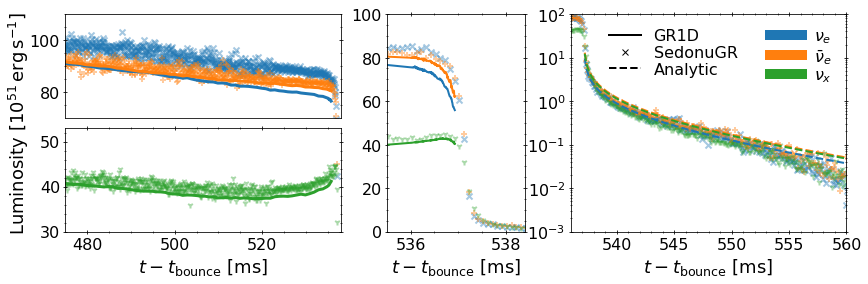

In [10]:
tbounce=.377756172723849759
c=29979245800.

fig = plt.figure(figsize=(14,4))
gs = gridspec.GridSpec(2, 3, width_ratios=[1, 0.5,1],hspace=0.1) 
ax0a = plt.subplot(gs[0,0])
ax0b = plt.subplot(gs[1,0])
ax1 = plt.subplot(gs[:,1])
ax2 = plt.subplot(gs[:,2])


factors = {0:1, 1:1, 2:4}
    
k = 0
for spectrum in spectra_sum:
    ## Sum time bins  
    spec = np.zeros(spectrum.shape[0])
    for i in range(spectrum.shape[1]):
            for j in range(spectrum.shape[0]):
                    if (j >= splitTime):
                            spec[j] += spectrum[j,i]/ timeBinWidths[1]/1e51/factors[k]
                    else:
                            spec[j] += spectrum[j,i] / timeBinWidths[0]/1e51/factors[k]
                            
    t = np.asarray(t_sum)
    y = np.asarray(spec)
    ax0a.scatter(t[t>440.]-tbounce*1000, y[t>440.], marker=marks[k%5],color=colours2[k],alpha=0.4)
    ax0b.scatter(t[t>440.]-tbounce*1000, y[t>440.], marker=marks[k%5],color=colours2[k],alpha=0.4)
    ax1.scatter(t[t>440.]-tbounce*1000, y[t>440.], marker=marks[k%5],color=colours2[k],alpha=0.4)
    ax2.scatter(t[t>440.]-tbounce*1000, y[t>440.], marker=marks[k%5],color=colours2[k],alpha=0.4)
    
    k += 1
    
    
radius = 4.0e7
quant='rho'
times = np.zeros(len(data[radius][quant]['time']))
for i in range(len(data[radius][quant]['time'])):
    times[i] = (data[radius][quant]['time'][i]-3.5e7/c-tbounce)*1000.

    #get_value_from_array_given_time(fulldata,1e11,'rho',ttime):
    
quant = 'M1_nue_luminosity_lab_rad'
ax0a.plot(times,data[radius][quant]['value']*data[radius]['lab_factor']['value']/1e51,'C0',linewidth=3)
quant = 'M1_anue_luminosity_lab_rad'
ax0a.plot(times,data[radius][quant]['value']*data[radius]['lab_factor']['value']/1e51,'C1',linewidth=3)
quant = 'M1_nux_luminosity_lab_rad'
ax0b.plot(times,data[radius][quant]['value']*data[radius]['lab_factor']['value']/4e51,'C2',linewidth=3)

radius = 0.5e7

times = np.zeros(len(data[radius][quant]['time']))
for i in range(len(data[radius][quant]['time'])):
    times[i] = (data[radius][quant]['time'][i]-tbounce)*1000.


quant = 'M1_nue_luminosity_lab_rad'
ax1.plot(times,data[radius][quant]['value']*data[radius]['lab_factor']['value']/1e51)
quant = 'M1_anue_luminosity_lab_rad'
ax1.plot(times,data[radius][quant]['value']*data[radius]['lab_factor']['value']/1e51)
quant = 'M1_nux_luminosity_lab_rad'
ax1.plot(times,data[radius][quant]['value']*data[radius]['lab_factor']['value']/4e51)

#analytic
analL = np.zeros(3)
analaveE = np.zeros(3)
analrmsE = np.zeros(3)
analSL = np.zeros(3)

NuPropstime = 535
index = np.argmin(abs(times-NuPropstime))
radius = 4.0e7
quant = 'M1_nue_luminosity_lab_rad'
analL[0] = data[radius][quant]['value'][index]*data[radius]['lab_factor']['value'][index]
quant = 'M1_anue_luminosity_lab_rad'
analL[1] = data[radius][quant]['value'][index]*data[radius]['lab_factor']['value'][index]
quant = 'M1_nux_luminosity_lab_rad'
analL[2] = data[radius][quant]['value'][index]*data[radius]['lab_factor']['value'][index]/4.

quant =  'M1_nue_aveenergy_fluid_rad'
analaveE[0] = data[radius][quant]['value'][index]*data[radius]['energy_factor']['value'][index]
quant = 'M1_anue_aveenergy_fluid_rad'
analaveE[1] = data[radius][quant]['value'][index]*data[radius]['energy_factor']['value'][index]
quant = 'M1_nux_aveenergy_fluid_rad'
analaveE[2] = data[radius][quant]['value'][index]*data[radius]['energy_factor']['value'][index]

quant =  'M1_nue_rmsenergy_fluid_rad'
analrmsE[0] = data[radius][quant]['value'][index]*data[radius]['energy_factor']['value'][index]
quant = 'M1_anue_rmsenergy_fluid_rad'
analrmsE[1] = data[radius][quant]['value'][index]*data[radius]['energy_factor']['value'][index]
quant = 'M1_nux_rmsenergy_fluid_rad'
analrmsE[2] = data[radius][quant]['value'][index]*data[radius]['energy_factor']['value'][index]

analalpha = (2.0 * analaveE**2 - analrmsE ** 2) / (analrmsE**2 -  analaveE ** 2)
anal3rdE = (3.0+analalpha)/(1.0+analalpha)*analaveE*analrmsE**2

ave_A = 56
W = 1.0-2.0*26.0/56.*(1.0-2.0*0.23)

sigma0 = 1.761e-44/(16.0)*(1.0/0.511)**2*ave_A**2*W**2
rho0=8e8
r0=3.5e6
NA=6.022e23
tBH = 914.6844-tbounce*1000+(deltat_10km_50km+4e6)*1000/c
analtime = np.linspace(0.1,26,160)
analSL = 2.*analL/analaveE*anal3rdE*sigma0*rho0*NA*(r0**3/29979245800)**(1/2)/ave_A
tau=10
#ax2.plot(tBH+analtime,analSL[0]*(1-1/np.sqrt(1+tau/analtime))*(analtime/1000.)**(-1/2)/1e51,"C0--")
#ax2.plot(tBH+analtime,analSL[1]*(1-1/np.sqrt(1+tau/analtime))*(analtime/1000.)**(-1/2)/1e51,"C1--")
#ax2.plot(tBH+analtime,analSL[2]*(1-1/np.sqrt(1+tau/analtime))*(analtime/1000.)**(-1/2)/1e51,"C2--")

#other analytic version
a = 5000e5/29979245800.
    
ax2.plot(tBH+analtime,analSL[0]*(-gamma(0.5)*gammaincc(0.5,analtime/1000./a)/np.sqrt(a) 
    + np.exp(-analtime/1000./a)/np.sqrt(analtime/1000.))/1e51,"C0--")

ax2.plot(tBH+analtime,analSL[1]*(- gamma(0.5)*gammaincc(0.5,analtime/1000./a)/np.sqrt(a) 
    + np.exp(-analtime/1000./a)/np.sqrt(analtime/1000.))/1e51,"C1--")

ax2.plot(tBH+analtime,analSL[2]*(- gamma(0.5)*gammaincc(0.5,analtime/1000./a)/np.sqrt(a) 
    + np.exp(-analtime/1000./a)/np.sqrt(analtime/1000.))/1e51,"C2--")



ax0a.set_xlim(475,538)
ax0a.set_ylim(70,110)
ax0a.get_xaxis().set_ticks([])

ax0b.set_xlim(475,538)
ax0b.set_ylim(30,53)
ax0b.set_xlabel("$t-t_\mathrm{bounce}$ [ms]")


ax1.set_xlim(535.5,538.4)
ax1.set_ylim(0,100)
ax1.set_xlabel("$t-t_\mathrm{bounce}$ [ms]")

#to compare with tm3/2 and tm1/2.
myt = np.linspace(0.0001,0.025,100)
myy12 = analSL[0]*myt**(-1/2)/1e51
#ax2.plot(1000*myt+537.2,myy12,'k--',alpha=0.3)
myy32 = analSL[0]*0.5*myt**(-3/2)/1e51*0.0001
#ax2.plot(1000*myt+537.2,myy32,'k--',alpha=0.3)

ax1.set_ylabel('Luminosity [$10^{51}\,\mathrm{erg}\,\mathrm{s}^{-1}$]', labelpad=320)
ax2.set_xlim(536,560)
ax2.set_ylim(0.001,100)
ax2.set_xlabel("$t-t_\mathrm{bounce}$ [ms]")
ax2.set_yscale('log')


ax2.plot([0,0],[1,1],"k",label="GR1D")
ax2.plot([0],[1],"kx",label="SedonuGR")
ax2.plot([0,0],[1,1],"k--",label="Analytic")

ax2.plot([0,0],[1,1],"C0",linewidth=10,label=r"$\nu_e$")
ax2.plot([0],[1],"C1",linewidth=10,label=r"$\bar{\nu}_e$")
ax2.plot([0,0],[1,1],"C2",linewidth=10,label=r"$\nu_x$")

ax2.legend(ncol=2)

plt.savefig("s40_lum_withMC.pdf",bbox_inches='tight')
plt.show()

<ipython-input-11-ef757d67d2cf>:29: RuntimeWarning: invalid value encountered in true_divide
  y = np.asarray(spec)/np.asarray(nspec)*erg_to_MeV


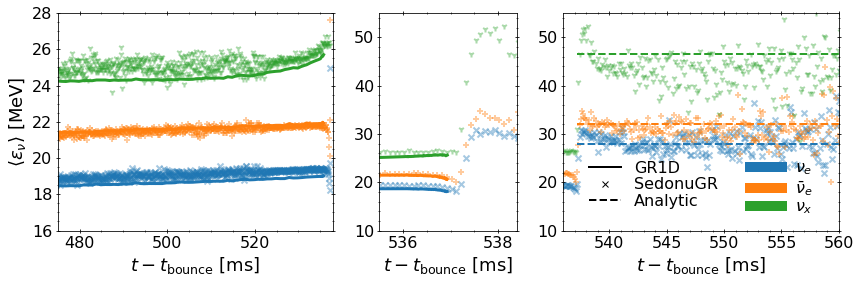

In [11]:
tbounce=.377756172723849759
c=29979245800.

fig = plt.figure(figsize=(14,4))
gs = gridspec.GridSpec(2, 3, width_ratios=[1, 0.5,1],hspace=0.1) 
ax0 = plt.subplot(gs[:,0])
ax1 = plt.subplot(gs[:,1])
ax2 = plt.subplot(gs[:,2])


factors = {0:1, 1:1, 2:4}
    
k = 0
for nspectrum in nspectra_sum:
    spectrum = spectra_sum[k]
    ## Sum time bins                                                                                                                                                                         
    spec = np.zeros(spectrum.shape[0])
    nspec = np.zeros(nspectrum.shape[0])
    for i in range(spectrum.shape[1]):
            for j in range(spectrum.shape[0]):
                    if (j >= splitTime):
                            spec[j] += spectrum[j,i]/ timeBinWidths[1]/1e51/factors[k]
                            nspec[j] += nspectrum[j,i]/ timeBinWidths[1]/1e51/factors[k]
                    else:
                            spec[j] += spectrum[j,i] / timeBinWidths[0]/1e51/factors[k]
                            nspec[j] += nspectrum[j,i] / timeBinWidths[0]/1e51/factors[k]
                            
    t = np.asarray(t_sum)
    y = np.asarray(spec)/np.asarray(nspec)*erg_to_MeV
    ax0.scatter(t[t>440.]-tbounce*1000, y[t>440.], marker=marks[k%5],color=colours2[k],alpha=0.4)
    ax1.scatter(t[t>440.]-tbounce*1000, y[t>440.], marker=marks[k%5],color=colours2[k],alpha=0.4)
    ax2.scatter(t[t>440.]-tbounce*1000, y[t>440.], marker=marks[k%5],color=colours2[k],alpha=0.4)
    
    k += 1    

radius = 4.0e7

quant='rho'
times = np.zeros(len(data[radius][quant]['time']))
for i in range(len(data[radius][quant]['time'])):
    times[i] = (data[radius][quant]['time'][i]-tbounce-3.5e7/c)*1000.
    
quant = 'M1_nue_aveenergy_fluid_rad'
ax0.plot(times,data[radius][quant]['value']*data[radius]['energy_factor']['value'],'C0',linewidth=3)
quant = 'M1_anue_aveenergy_fluid_rad'
ax0.plot(times,data[radius][quant]['value']*data[radius]['energy_factor']['value'],'C1',linewidth=3)
quant = 'M1_nux_aveenergy_fluid_rad'
ax0.plot(times,data[radius][quant]['value']*data[radius]['energy_factor']['value'],'C2',linewidth=3)

radius = 0.5e7

times = np.zeros(len(data[radius][quant]['time']))
for i in range(len(data[radius][quant]['time'])):
    times[i] = (data[radius][quant]['time'][i]-tbounce)*1000.

    
quant = 'M1_nue_aveenergy_fluid_rad'
ax1.plot(times,data[radius][quant]['value']*data[radius]['energy_factor']['value'],'C0',linewidth=3)
quant = 'M1_anue_aveenergy_fluid_rad'
ax1.plot(times,data[radius][quant]['value']*data[radius]['energy_factor']['value'],'C1',linewidth=3)
quant = 'M1_nux_aveenergy_fluid_rad'
ax1.plot(times,data[radius][quant]['value']*data[radius]['energy_factor']['value'],'C2',linewidth=3)


#analytic
analL = np.zeros(3)
analaveE = np.zeros(3)
analrmsE = np.zeros(3)
analSL = np.zeros(3)

NuPropstime = 535
index = np.argmin(abs(times-NuPropstime))
radius = 4.0e7
quant = 'M1_nue_luminosity_lab_rad'
analL[0] = data[radius][quant]['value'][index]*data[radius]['lab_factor']['value'][index]
quant = 'M1_anue_luminosity_lab_rad'
analL[1] = data[radius][quant]['value'][index]*data[radius]['lab_factor']['value'][index]
quant = 'M1_nux_luminosity_lab_rad'
analL[2] = data[radius][quant]['value'][index]*data[radius]['lab_factor']['value'][index]/4.

quant =  'M1_nue_aveenergy_fluid_rad'
analaveE[0] = data[radius][quant]['value'][index]*data[radius]['energy_factor']['value'][index]
quant = 'M1_anue_aveenergy_fluid_rad'
analaveE[1] = data[radius][quant]['value'][index]*data[radius]['energy_factor']['value'][index]
quant = 'M1_nux_aveenergy_fluid_rad'
analaveE[2] = data[radius][quant]['value'][index]*data[radius]['energy_factor']['value'][index]

quant =  'M1_nue_rmsenergy_fluid_rad'
analrmsE[0] = data[radius][quant]['value'][index]*data[radius]['energy_factor']['value'][index]
quant = 'M1_anue_rmsenergy_fluid_rad'
analrmsE[1] = data[radius][quant]['value'][index]*data[radius]['energy_factor']['value'][index]
quant = 'M1_nux_rmsenergy_fluid_rad'
analrmsE[2] = data[radius][quant]['value'][index]*data[radius]['energy_factor']['value'][index]

analalpha = (2.0 * analaveE**2 - analrmsE ** 2) / (analrmsE**2 -  analaveE ** 2)
anal3rdE = (3.0+analalpha)/(1.0+analalpha)*analaveE*analrmsE**2
anal4thE = (4.0+analalpha)/(1.0+analalpha)*analaveE*anal3rdE
anal5thE = (5.0+analalpha)/(1.0+analalpha)*analaveE*anal4thE

tBH = 914.6844-tbounce*1000+(deltat_10km_50km+4e6)*1000/c
analtime = np.linspace(0.1,26,2)

analE0 = anal3rdE[0]/analrmsE[0]**2*np.linspace(1,1,2)
analE1 = anal3rdE[1]/analrmsE[1]**2*np.linspace(1,1,2)
analE2 = anal3rdE[2]/analrmsE[2]**2*np.linspace(1,1,2)
ax2.plot(tBH+analtime,analE0,"C0--")
ax2.plot(tBH+analtime,analE1,"C1--")
ax2.plot(tBH+analtime,analE2,"C2--")


ax0.set_xlim(475,538)
ax0.set_ylim(16,28)
ax0.set_xlabel("$t-t_\mathrm{bounce}$ [ms]")
ax0.set_ylabel(r"$\langle \epsilon_\nu \rangle$ [MeV]")


ax1.set_xlim(535.5,538.4)
ax1.set_ylim(10,55)
ax1.set_xlabel("$t-t_\mathrm{bounce}$ [ms]")

ax2.set_xlim(536,560)
ax2.set_ylim(10,55)
ax2.set_xlabel("$t-t_\mathrm{bounce}$ [ms]")


ax2.plot([0,0],[1,1],"k",label="GR1D")
ax2.plot([0],[1],"kx",label="SedonuGR")
ax2.plot([0,0],[1,1],"k--",label="Analytic")

ax2.plot([0,0],[1,1],"C0",linewidth=10,label=r"$\nu_e$")
ax2.plot([0],[1],"C1",linewidth=10,label=r"$\bar{\nu}_e$")
ax2.plot([0,0],[1,1],"C2",linewidth=10,label=r"$\nu_x$")

ax2.legend(ncol=2)

plt.savefig("s40_ave_withMC.pdf",bbox_inches='tight')
plt.show()